<a href="https://colab.research.google.com/github/kkkkkostya/ApP/blob/master/X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X_ray dataset


In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.8 MB/s eta 0:00:00


In [3]:
import warnings

import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.transforms.v2 as T
import optuna
import torch.optim as optim

from optuna.trial import TrialState
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from torchsummary import summary
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output

warnings.filterwarnings('ignore')

### Downloading dataset


In [4]:
!pip install -q kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp /kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 140MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.2MB/s]


In [9]:
!unzip /content/chest-xray-pneumonia.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jp

In [10]:
!rm -rf /content/chest_xray/chest_xray

In [11]:
!rm -rf /content/chest_xray/__MACOSX

In [12]:
!rm -rf /content/chest-xray-pneumonia.zip

In [ ]:
# labels = ['PNEUMONIA', 'NORMAL']
# img_size = 150
# def get_data(data_dir):
#     data = []
#     for label in tqdm(labels):
#         path = os.path.join(data_dir,label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img = Image.open(os.path.join(path, img))
#                 data.append([img.load(), class_num])
#                 img.close()
#             except Exception as e:
#                 print(e)
#     return np.array(data)

In [ ]:
# train = get_data(r'/content/chest_xray/train')
# test = get_data(r'/content/chest_xray/test')
# val = get_data(r'/content/chest_xray/val')


  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
class XrayDataset(Dataset):
    SPLIT_RANDOM_SEED = 42

    def __init__(self, root, transform=None):
        super().__init__()
        self.root = root
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            self.all_files += files
            self.all_labels += [i] * len(files)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        filename = self.all_files[item]
        image = Image.open(os.path.join(self.root, self.classes[label], filename))

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [270]:
train_data = XrayDataset(root='/content/chest_xray/train')
test_data = XrayDataset(root='/content/chest_xray/test')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

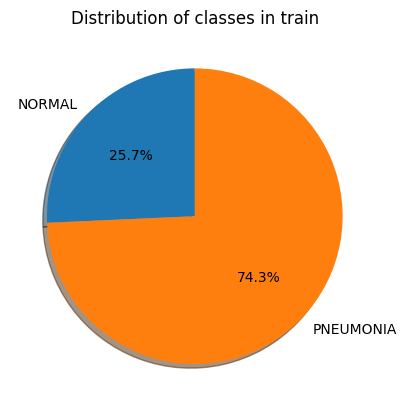

In [ ]:
image_count={}
for i in train_data.classes:
    image_count[i] = len(os.listdir(os.path.join('/content/chest_xray/train',i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
ax1.set_title("Distribution of classes in train")
plt.show()

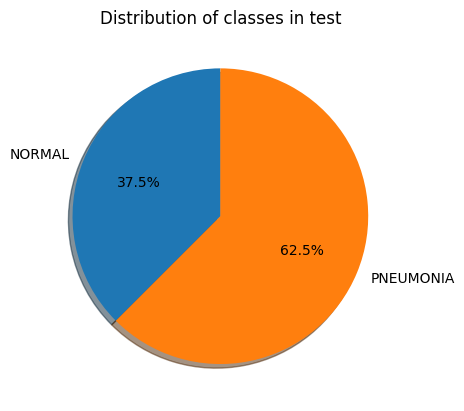

In [15]:
image_count={}
for i in test_data.classes:
    image_count[i] = len(os.listdir(os.path.join('/content/chest_xray/test',i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
ax1.set_title("Distribution of classes in test")
plt.show()

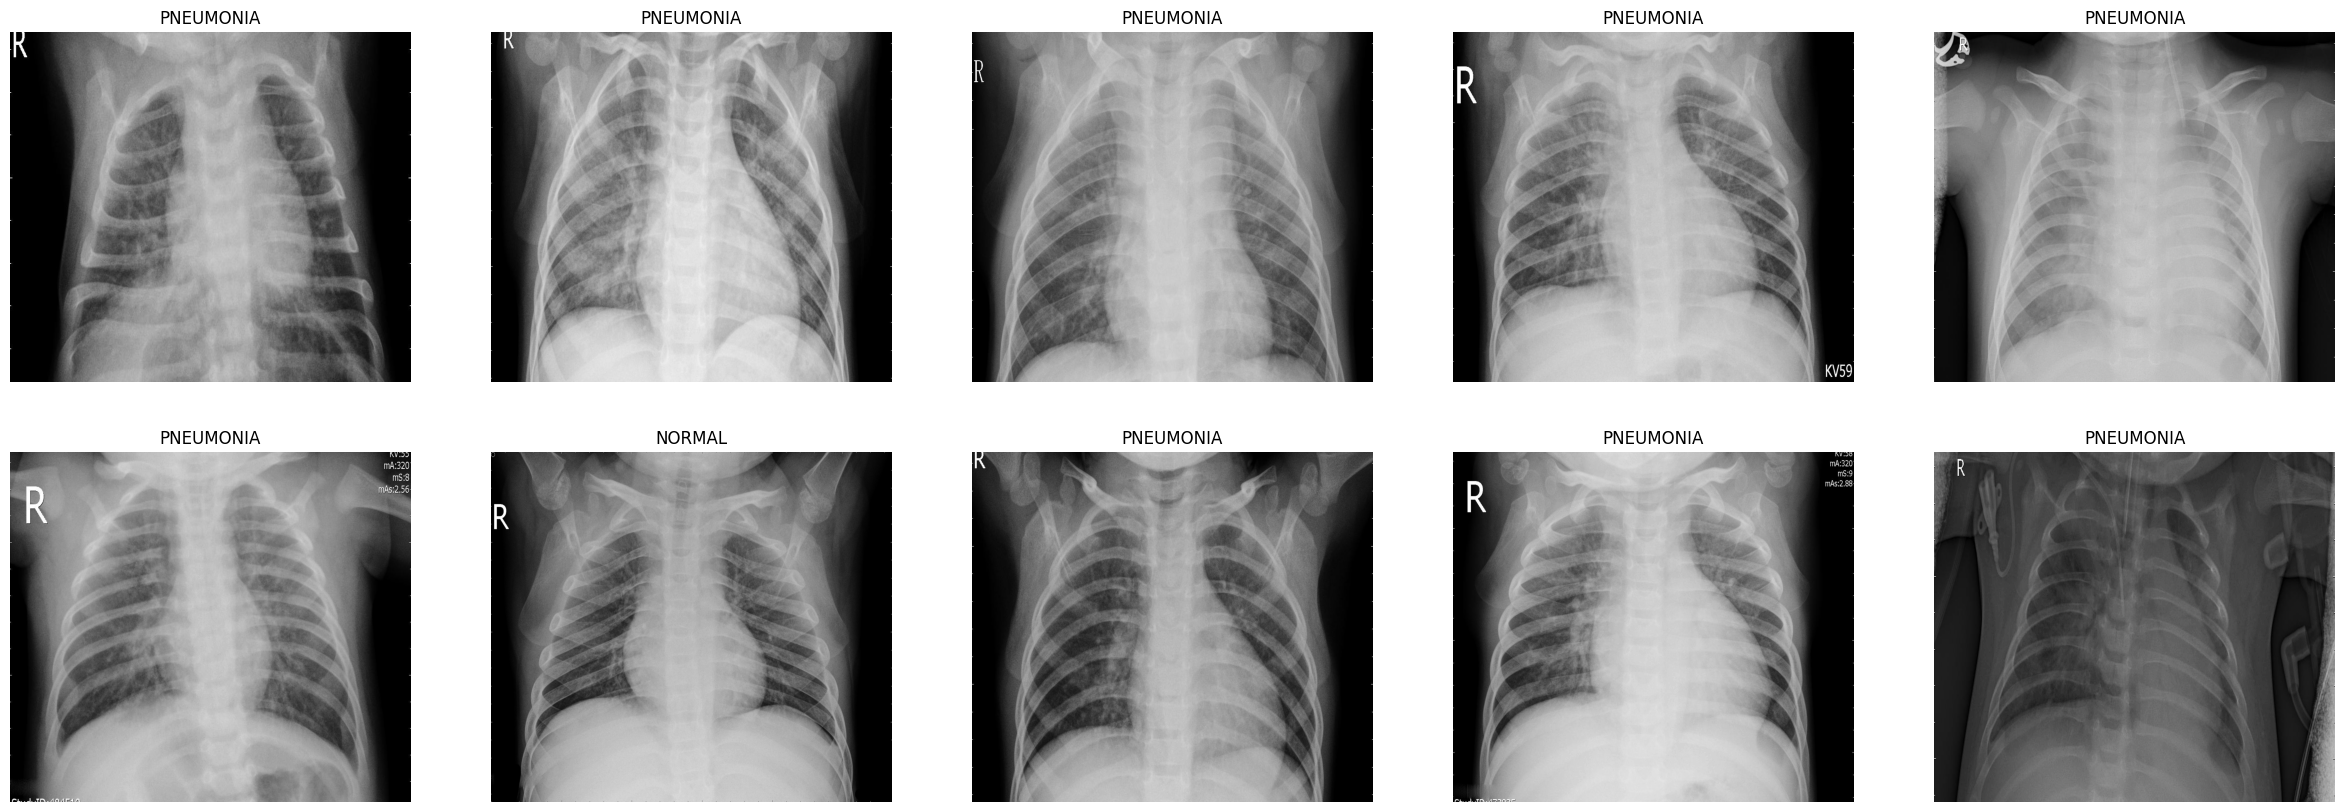

In [ ]:
indexes = np.random.randint(0,len(train_data),10)
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    ax[i//5, i%5].imshow(train_data[indexes[i]][0], cmap='gray')
    ax[i//5, i%5].set_title(train_data.classes[train_data[indexes[i]][1]])
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [14]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.Resize((256,256)),
    T.RandomRotation(10),   # for firstnet 10
    T.RandomHorizontalFlip(p=0.4),
    T.ToTensor(),
    normalize
])

val_transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    normalize
])

test_transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    normalize
])

In [234]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.Resize((150,150)),
    T.RandomRotation(20),
    T.RandomHorizontalFlip(p=0.4),
    T.ToTensor(),
    normalize
])

val_transform = T.Compose([
    T.Resize((150,150)),
    T.CenterCrop(150),
    T.RandomRotation(20),
    T.ToTensor(),
    normalize
])

test_transform = T.Compose([
    T.Resize((150,150)),
    T.ToTensor(),
    normalize
])

In [15]:
train = XrayDataset(root='/content/chest_xray/train',transform=train_transform)
test = XrayDataset(root='/content/chest_xray/test',transform=test_transform)
val = XrayDataset(root='/content/chest_xray/val',transform=val_transform)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
train_loader = DataLoader(train, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val, batch_size=8, shuffle=False, pin_memory=True, num_workers=4)

In [17]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on CPU


In [18]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [19]:
def training_epoch(model, scheduler, criterion, optimizer, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        #dense modif
        #if scheduler is not None:
         # scheduler.step()


        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy

In [20]:
@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


In [21]:
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    since = time.time()
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_acc = np.NINF

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, scheduler, criterion, optimizer, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
           scheduler.step(test_loss)  # if ReduceLROnPlateau

        if test_loss < best_loss:
          best_loss = test_loss
          best_model_wts = copy.deepcopy(model.state_dict())

        if test_accuracy > best_acc:
          best_acc = test_accuracy

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    time_since = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))
    print('Best val acc: {:.4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

## **Own net**

In [252]:
class SecondNet(nn.Module):
    def __init__(self, image_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, padding='same', kernel_size=3),  #  32 x 256 x 256  32, 150, 150
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  #  32 x 128 x 128  32 75 75

            nn.Conv2d(in_channels = 32, out_channels=64, padding='same', kernel_size=3),  #  64 x 128 x 128  64 75 75
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  #  64 x 64 x 64  64 37 37

            nn.Conv2d(in_channels = 64, out_channels=64, padding='same', kernel_size=3),  #  64 x 64 x 64  64 37 37
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  #  64 x 32 x 32  64 18 18


            nn.Conv2d(in_channels = 64, out_channels=128, padding='same', kernel_size=3),  #  128 x 32 x 32      128 18 18
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  #  128 x 16 x 16      128 9 9

            nn.Conv2d(in_channels = 128, out_channels=256, padding='same', kernel_size=3),  #  256 x 16 x 16      256 9 9
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),  #  256 x 8 x 8    256 4 4

            nn.Flatten()  # 4096
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=4096 , out_features=128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features = 128, out_features=2)
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.head(out)
        return out

In [253]:
model = SecondNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3,patience=2,verbose =True, min_lr = 0.000001)

Size 150 150

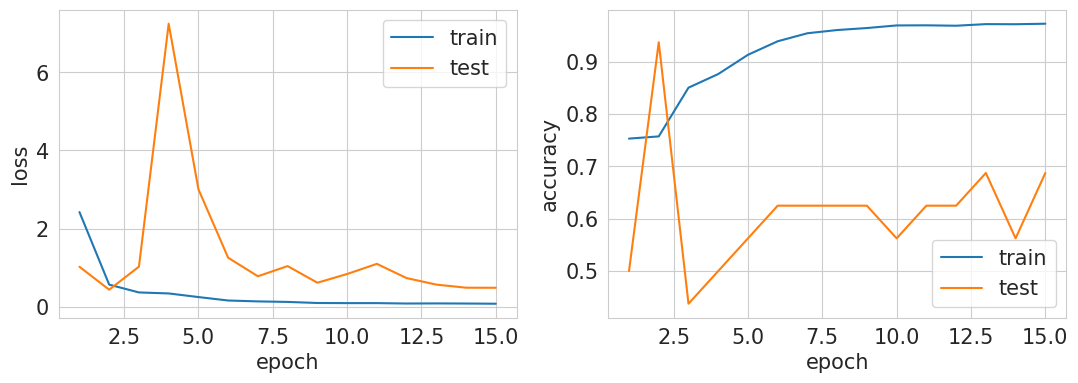

Training complete in 12m 52s
Best val loss: 0.4325
Best val acc: 0.9375


In [254]:
base_model = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs=15)

In [255]:
y_pred_list = []
y_true_list = []
y_prob = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        pr = torch.softmax(y_test_pred, dim=1)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_prob.append(pr.cpu().numpy())
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

y_pred_ = np.array(y_pred_list).flatten()
y_true_ = np.array(y_true_list).flatten()
y_prob =  [k[1] for a in y_prob for k in a]

  0%|          | 0/78 [00:00<?, ?it/s]

In [256]:
roc_auc_score(y_true_, y_prob)

0.8785119438965594

In [257]:
print(classification_report(y_true_, y_pred_))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       234
           1       0.93      0.73      0.82       390

    accuracy                           0.80       624
   macro avg       0.80      0.82      0.80       624
weighted avg       0.83      0.80      0.80       624



250 250 size

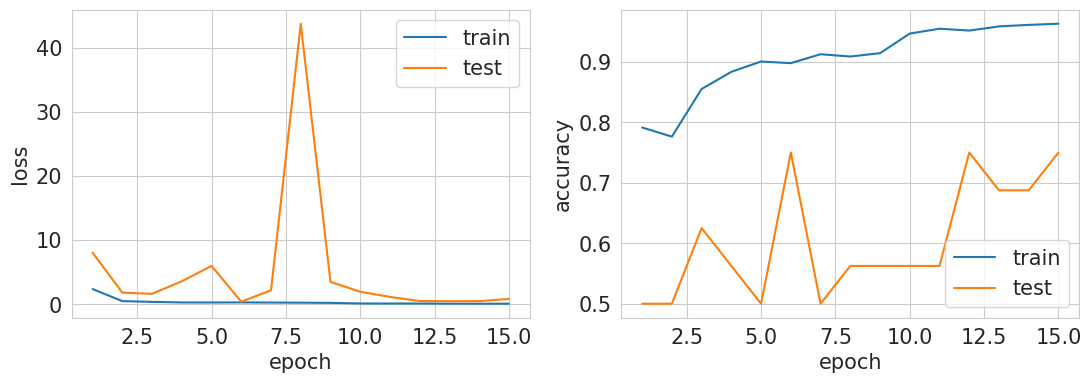

Training complete in 14m 56s
Best val loss: 0.4209
Best val acc: 0.7500


In [187]:
base_model = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs=15)

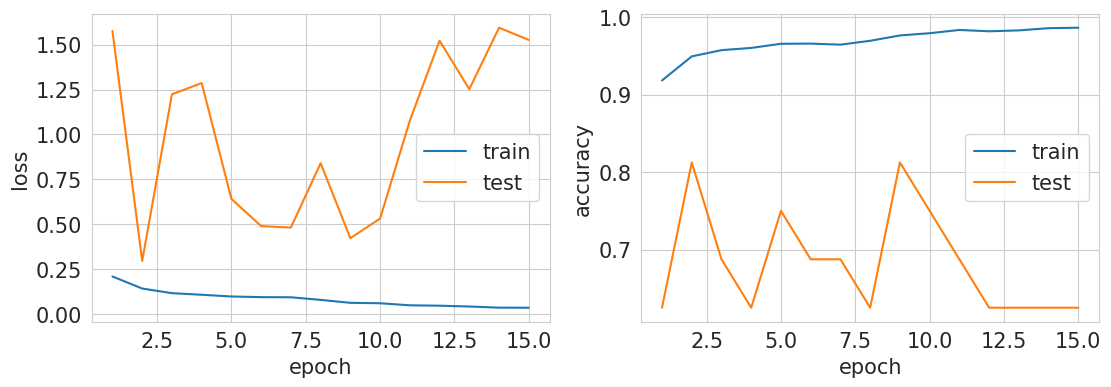

Training complete in 14m 45s
Best val loss: 0.2960
Best val acc: 0.8125


In [149]:
base_model = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs=15)

In [188]:
y_pred_list = []
y_true_list = []
y_prob = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        pr = torch.softmax(y_test_pred, dim=1)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_prob.append(pr.cpu().numpy())
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

y_pred_ = np.array(y_pred_list).flatten()
y_true_ = np.array(y_true_list).flatten()
y_prob =  [k[1] for a in y_prob for k in a]

  0%|          | 0/78 [00:00<?, ?it/s]

In [189]:
roc_auc_score(y_true_, y_prob)

0.9136916502301118

In [190]:
print(classification_report(y_true_, y_pred_))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       234
           1       0.84      0.93      0.89       390

    accuracy                           0.85       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.85      0.85       624



In [22]:
class FirstNet(nn.Module):
    def __init__(self, image_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, padding='same', kernel_size=3),  #  32 x 256 x 256
            nn.ReLU(),
            nn.MaxPool2d(2),  #  32 x 128 x 128
            nn.Dropout(0.2),

            nn.Conv2d(in_channels = 32, out_channels=64, padding='same', kernel_size=3),  #  64 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(2),  #  64 x 64 x 64
            nn.Dropout(0.1),

            nn.Conv2d(in_channels = 64, out_channels=128, padding='same', kernel_size=3),  #  128 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2),  #  128 x 32 x 32
            nn.Dropout(0.3),


            nn.Conv2d(in_channels = 128, out_channels=256, padding='same', kernel_size=3),  #  256 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2),  #  256 x 16 x 16
            nn.Dropout(0.2),

            nn.Conv2d(in_channels = 256, out_channels=256, stride=2, kernel_size=3),  #  256 x 7 x 7
            nn.ReLU(),
            nn.MaxPool2d(2),  #  256 x 3 x 3
            nn.Dropout(0.2),

            nn.Flatten()  # 2304
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=2304 , out_features=256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features=2)
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.head(out)
        return out

In [140]:
model = FirstNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15)

In [ ]:
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
           Dropout-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
           Dropout-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
             ReLU-10          [-1, 128, 64, 64]               0
        MaxPool2d-11          [-1, 128, 32, 32]               0
          Dropout-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
             ReLU-14          [-1, 256,

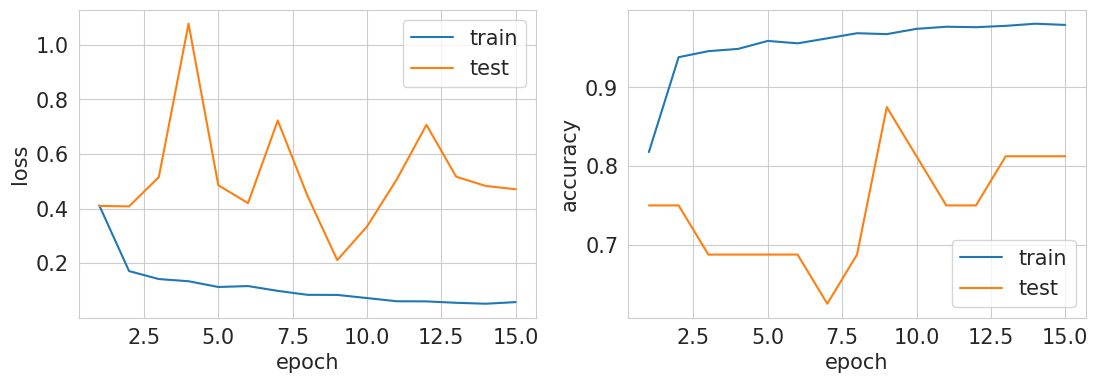

Training complete in 15m 12s
Best val loss: 0.2114
Best val acc: 0.8750


In [ ]:
base_model = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs=15)

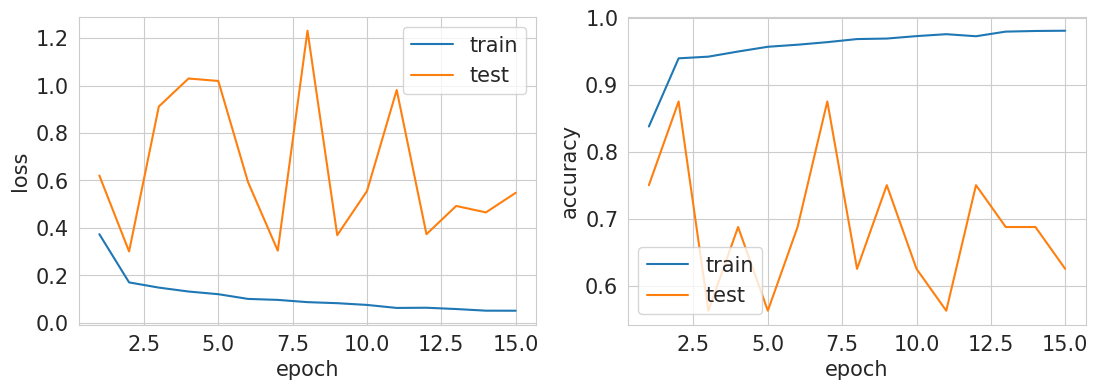

Training complete in 14m 54s
Best val loss: 0.3011
Best val acc: 0.8750


In [82]:
base_model = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs=15)

In [83]:
y_pred_list = []
y_true_list = []
y_prob = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        pr = torch.softmax(y_test_pred, dim=1)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_prob.append(pr.cpu().numpy())
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/78 [00:00<?, ?it/s]

In [84]:
y_pred_ = np.array(y_pred_list).flatten()
y_true_ = np.array(y_true_list).flatten()
y_prob =  [k[1] for a in y_prob for k in a]

Best FirstNet

In [87]:
roc_auc_score(y_true_, y_prob)

0.9541639272408503

In [86]:
print(classification_report(y_true_, y_pred_))

              precision    recall  f1-score   support

           0       0.95      0.61      0.74       234
           1       0.81      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.88      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



In [ ]:
roc_auc_score(y_true_, y_prob)

0.9441595441595443

In [ ]:
print(classification_report(y_true_, y_pred_))

              precision    recall  f1-score   support

           0       0.96      0.56      0.70       234
           1       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



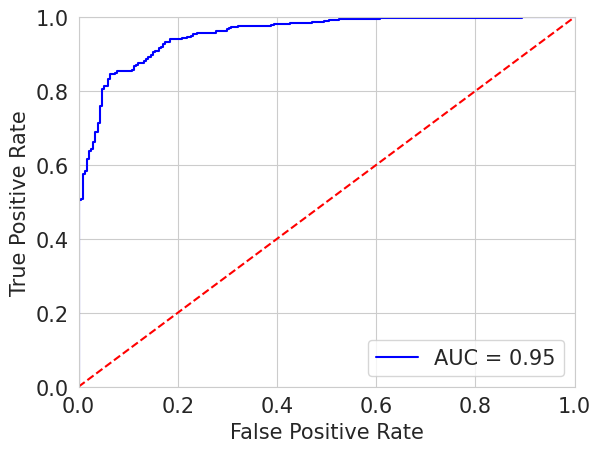

In [88]:
fpr, tpr, threshold = metrics.roc_curve(y_true_, y_prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Optuna**

In [27]:
def objective(trial):
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
  t_max = trial.suggest_int("T_max", 10, 15, step=1)
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = t_max)
  critertion = nn.CrossEntropyLoss()


  for epoch in range(1, t_max):
      train_loss, train_accuracy = training_epoch(
          model, scheduler, critertion, optimizer, train_loader,
          tqdm_desc=f'Training {epoch}/{t_max}'
      )
      test_loss, test_accuracy = validation_epoch(
          model, critertion, test_loader,
          tqdm_desc=f'Validating {epoch}/{t_max}'
      )

      if scheduler is not None:
          scheduler.step()

      trial.report(test_accuracy, epoch)

      if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
  return test_accuracy

In [28]:
model = FirstNet().to(device)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-06 15:50:46,371] A new study created in memory with name: no-name-d98a8bba-c88c-48c6-a26f-9f863064f4a3


Training 1/15:   0%|          | 0/652 [00:00<?, ?it/s]

[W 2023-12-06 15:52:42,193] Trial 0 failed with parameters: {'optimizer': 'Adam', 'T_max': 15, 'lr': 0.009576394297345817} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-27-626bbdc2ddfc>", line 11, in objective
    train_loss, train_accuracy = training_epoch(
  File "<ipython-input-19-c6a0232f2841>", line 9, in training_epoch
    logits = model(images)  # logits: batch_size x num_classes
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-22-ddf8a0b92efc>", line 41, in forward
    out = self.encoder(x)
  File "/usr/local/lib/pyt

KeyboardInterrupt: ignored

## **DenseNet**


In [117]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, 2) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

dense_mo = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Specify optimizer which performs Gradient Descent
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Schedule

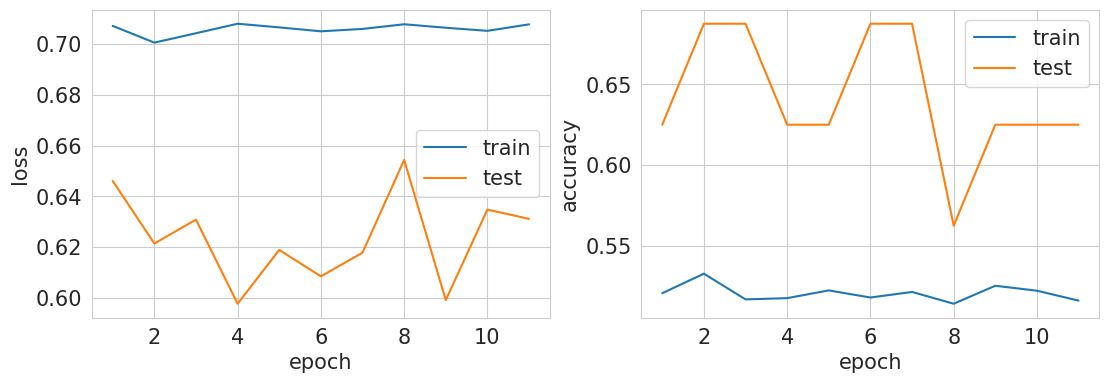

In [ ]:
dense_model = train(dense_mo, optimizer, exp_lr_scheduler, criterion, train_loader, val_loader, num_epochs=12)